This notebook shows how to use the SWOT PIXC processing tools.

NOTE to self: Use HyroEO environment for downloading SWOT PIXC data (uv env with proper netcdf with hdf5 installed), but use hydroeo (mamba env) for processing (no package errors with scipy and other geospatial packages)

In [7]:
# First lets load the needed packages
import sys
import geopandas as gpd
import datetime
import os
import glob
import matplotlib.pyplot as plt 
import matplotlib.cm as cm


sys.path.append("C:\\Users\\safr\\Documents\\github\\eo_analysis_usangu\\code")

import eo_tools as eot


outdir = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\"
if not os.path.exists(outdir):
    os.makedirs(outdir)

swot_raster_dir = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\"
if not os.path.exists(swot_raster_dir):
    os.makedirs(swot_raster_dir)

hist_dir = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\histograms\\"
if not os.path.exists(hist_dir):
    os.makedirs(hist_dir)

### View area of interest

<Axes: >

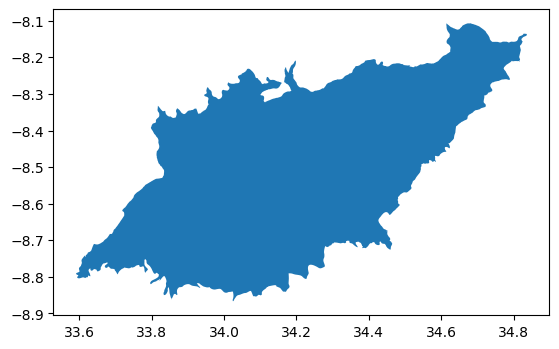

In [3]:
wetland_utm = gpd.read_file("C:\\Users\\safr\\Documents\\test_altimetry_project\\shapefiles\\wetland_fans_domain_37S.shp")
wetland_ll = wetland_utm.to_crs("EPSG:4326")
wetland_ll.plot()

### Load in trimmed data

<Axes: >

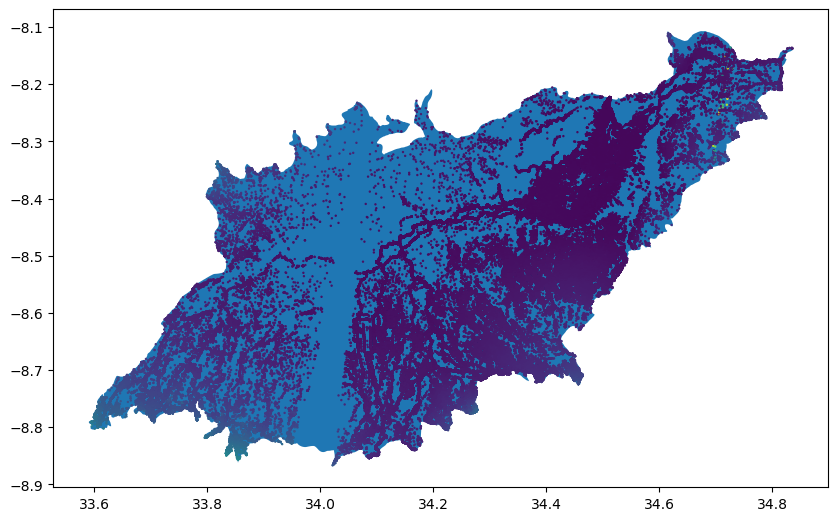

In [4]:
# Read in trimmed data, save to gdf_pixc_all
gdf_pixc_all = eot.load_trimmed_pixc_data(glob.glob("C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\PIXC\\*_trimmed.geojson")[0:15])

# plot
fig, ax = plt.subplots(figsize=(10,10))
wetland_ll.plot(ax=ax)
gdf_pixc_all.plot(ax=ax,column='heightEGM',s=0.5)

## Plot data by date, with histogram for each day

C:\Users\safr\AppData\Local\Temp\ipykernel_31172\966865024.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(dates))  # or tab20 if many dates


,height,heightEGM,lat,lon,geoid,solid_earth_tide,load_tide,pole_tide,class,water_frac,phase_noise_std,dheight_dphase,sig0,geometry,timestamp
date,,,,,,,,,,,,,,,
2023-07-28 02:34:53,1262.3553,1275.9749,-8.857156,33.855016,-13.568743,-0.061513,0.010042,0.000780,3.0,0.246260,0.143576,-7.627758,3.468229,POINT (33.85502 -8.85716),2023-07-28
2023-07-28 02:34:53,1235.5933,1249.2991,-8.848952,33.851782,-13.655022,-0.061504,0.010039,0.000779,3.0,0.282769,0.140401,-7.554225,3.895596,POINT (33.85178 -8.84895),2023-07-28
2023-07-28 02:34:53,1253.4138,1267.0839,-8.849335,33.834252,-13.619216,-0.061557,0.010032,0.000780,3.0,0.171959,0.193401,-7.266195,2.261579,POINT (33.83425 -8.84933),2023-07-28
2023-07-28 02:34:53,1249.6873,1263.3636,-8.848741,33.834252,-13.625625,-0.061555,0.010032,0.000780,3.0,0.137404,0.162680,-7.264735,1.890522,POINT (33.83425 -8.84874),2023-07-28
2023-07-28 02:34:53,1249.5082,1263.1846,-8.848720,33.834115,-13.625597,-0.061556,0.010032,0.000780,3.0,0.127135,0.162680,-7.262435,1.911662,POINT (33.83412 -8.84872),2023-07-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-08 15:12:33,1028.1460,1043.7777,-8.157674,34.801822,-15.631997,-0.010350,0.008927,0.001671,4.0,1.744163,0.121160,1.155615,111.647430,POINT (34.80182 -8.15767),2023-10-08
2023-10-08 15:12:33,1025.9196,1041.5288,-8.150549,34.819204,-15.609569,-0.010308,0.008934,0.001669,3.0,0.996173,0.163644,1.424065,14.358890,POINT (34.8192 -8.15055),2023-10-08
2023-10-08 15:12:33,1030.3661,1045.9718,-8.149737,34.821740,-15.606119,-0.010301,0.008935,0.001669,3.0,1.051944,0.112972,1.463794,9.335209,POINT (34.82174 -8.14974),2023-10-08


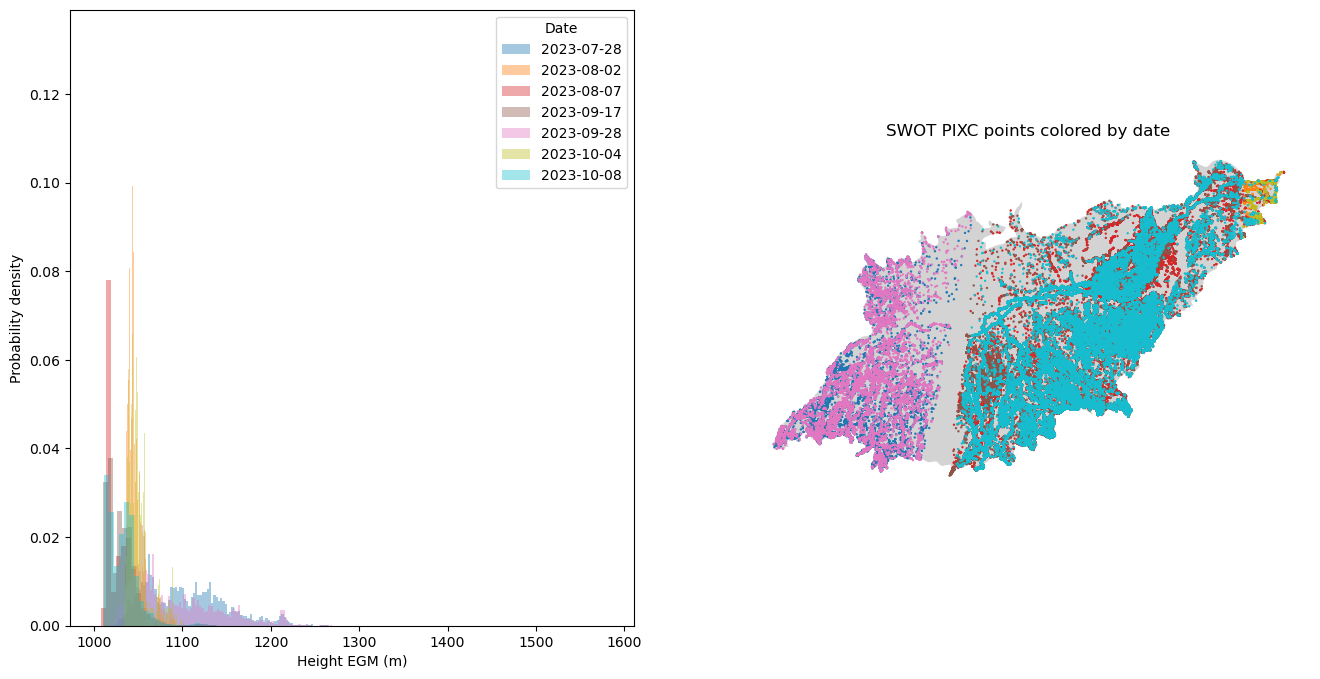

In [8]:
gdf_pixc_all['timestamp'] = gdf_pixc_all.index.date

dates = sorted(gdf_pixc_all['timestamp'].unique())
cmap = cm.get_cmap("tab10", len(dates))  # or tab20 if many dates

date_to_color = {
    date: cmap(i) for i, date in enumerate(dates)
}

fig, (ax_hist, ax_map) = plt.subplots(
    ncols=2,
    figsize=(16, 8),
    gridspec_kw={"width_ratios": [1, 1]}
)

for date, grp in gdf_pixc_all.groupby('timestamp'):
    ax_hist.hist(
        grp['heightEGM'],
        bins=100,
        alpha=0.4,
        color=date_to_color[date],
        density=True,
        label=str(date)
    )

ax_hist.set_xlabel("Height EGM (m)")
ax_hist.set_ylabel("Probability density")
ax_hist.legend(title="Date")

# Background
wetland_ll.plot(ax=ax_map, color="lightgrey", edgecolor="none")

# Points colored by date
gdf_pixc_all.plot(
    ax=ax_map,
    color=[date_to_color[date] for date in gdf_pixc_all['timestamp']],
    categorical=True,
    legend=True,
    markersize=0.5
)

ax_map.set_title("SWOT PIXC points colored by date")
ax_map.set_axis_off()

gdf_pixc_all

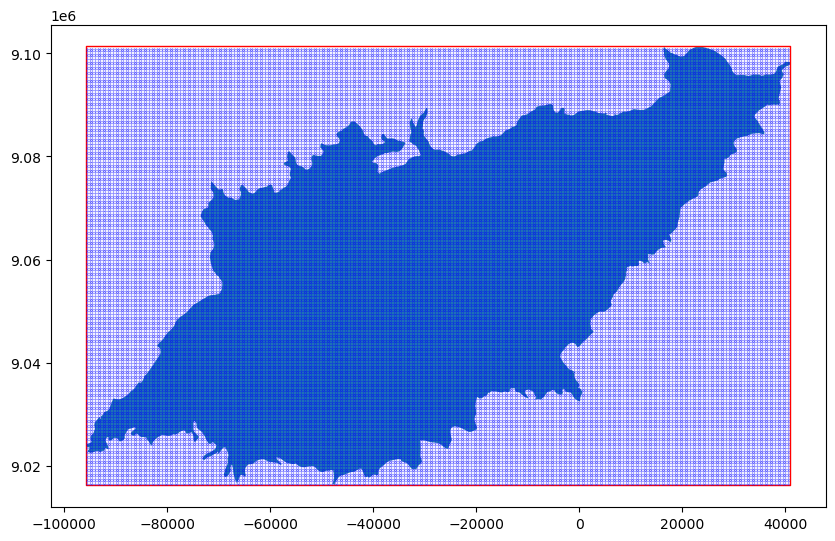

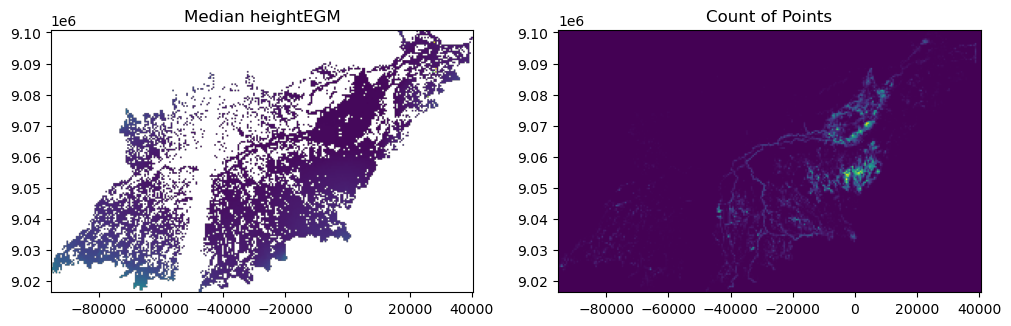

In [10]:
# First, try simple binning to 100m grid cells, taking median of points in each cell
grid_size = 500  # in meters
wetland_utm = wetland_ll.to_crs(epsg=32737)  # UTM zone 37S
gdf_pixc_all_utm = gdf_pixc_all.to_crs(epsg=32737)

# Test for all dates
stat_raster = eot.grid_sampling(
    shapefile_utm=wetland_utm,
    gdf_points=gdf_pixc_all_utm,
    buffer=0.01,
    field='heightEGM',
    stat_method='median',
    grid_resolution=grid_size,
    filedate='all_dates_sub',
    plotFlag=True,
    writeGeoTIFF=False,
    swot_raster_dir=swot_raster_dir
)

In [ ]:
# Processing 2 ways: WRT river centerlines, gridded raster (variable resolution)

# Processing group 1: Gridded raster approach





















